<a href="https://colab.research.google.com/github/12dylan3/LSTockMarket-Predictions/blob/main/Walmart_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
from functools import reduce
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time

Preprocess

In [3]:
def get_data(url_stock, url_gas, combine):
    """
    read the stock data and split into train and test
    :param url_stock: url string to raw stock data csv from github.
    :param url_gas: url string to raw gas data csv from github.
    :param combine: boolean True if adding gas data for prediction
    :return: Tuple of train_sequences, train_labels, and test_sequences, test_labels, and the scalar
    """
    # Done TODO: load training data from training file.
    test_ratio = 0.2
    sequence_length = 50
    
    stock_data = pd.read_csv(url_stock, date_parser=True)
    gas_data = pd.read_csv(url_gas, date_parser=True)

    stock_data['Date']=pd.to_datetime(stock_data['Date'])
    gas_data['Date']=pd.to_datetime(gas_data['Date'])
    if combine is True:
      print(stock_data)
      print(gas_data)
      data = pd.merge(stock_data, gas_data, on = 'Date', how = 'left')
      print(data)
      data = data.drop(['Date', 'Adj Close'], axis=1)
      print(data)
    else:
      data = stock_data.drop(['Date', 'Adj Close'], axis=1)


    num_data_points = data.shape[0]
    split_index = math.floor(num_data_points*(1-test_ratio))

    train_data = data[:split_index]
    test_data = data[split_index-sequence_length:]

    #Why do this? This turns everything into [0,1]
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)

    train_sequences = []
    train_labels = []
    for i in range(sequence_length, train_data.shape[0]):
      train_sequences.append(train_data[i-sequence_length:i])
      train_labels.append(train_data[i, 0])
    
    test_sequences = []
    test_labels = []
    for i in range(60, test_data.shape[0]):
      test_sequences.append(test_data[i-sequence_length:i])
      test_labels.append(test_data[i, 0])

                     
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)

    test_sequences = np.array(test_sequences)
    test_labels = np.array(test_labels)

    return (train_sequences, train_labels, test_sequences, test_labels, scaler)

Model Class

In [9]:
class Model(tf.keras.Model):
    def __init__(self, with_gas_data):
        """
        The Model class predicts the next day's opening stock price given a sequence of previous days.

        :param with_gas_data: Boolean indicating if gas prices have been added
        """

        super(Model, self).__init__()

        self.batch_size = 64
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=.001)
        if with_gas_data is True:
          self.lstm1 = tf.keras.layers.LSTM(96, activation='relu', input_shape = (50,6))
        else:
          self.lstm1 = tf.keras.layers.LSTM(96, activation='relu', input_shape = (50,5))
        
        self.d1 = tf.keras.layers.Dense(60, activation='relu')
        self.d2 = tf.keras.layers.Dense(50, activation='relu')
        self.d3 = tf.keras.layers.Dense(20, activation='relu')
        
        self.dropout1 = tf.keras.layers.Dropout(.10)

        self.final_dense = tf.keras.layers.Dense(1)



    def call(self, train_sequences):
        """
        :param train_sequences: stock data for sequence_length day period of shape (batch_size, sequence_length, 1)
        :return: the scaled predicted opening price for the next (sequence_length + 1st) day 
        """
        output = self.lstm1(train_sequences)
        output = self.dropout1(output)
        output = self.d1(output)
        output = self.d2(output)
        output = self.d3(output)
        output = self.final_dense(output)
        output = tf.convert_to_tensor(output)
        
        return output

    def loss(self, predictions, labels):
        """
        Calculates average cross entropy sequence to sequence loss of the prediction
        
        NOTE: You have to use np.reduce_mean and not np.reduce_sum when calculating your loss

        :param predictions: a matrix of shape (batch_size, 1) as a tensor
        :param labels: matrix of shape (batch_size, 1) containing the labels
        :return: the loss of the model as a tensor of size 1
        """

        loss = tf.keras.losses.mean_squared_error(labels, predictions)
        loss = tf.reduce_mean(loss)

        return loss

Train and Results

In [13]:
def train(model, train_sequences, train_labels):
    """
    Runs through one epoch - all training examples.

    :param model: the initilized model to use for forward and backward pass
    :param train_sequences: train inputs (all inputs for training) of shape (num_sequences, sequence_length, 1)
    :param train_labels: train labels (all labels for training) of shape (num_sequences, 1)
    :return: None
    """
    #TODO: Fill in
    print("In Train")

    i = 0
    count = 0
    while i < len(train_sequences)-model.batch_size:
        print("Batch number: " + str(count))
        batch_inputs = train_sequences[i:i+model.batch_size]
        print(np.shape(batch_inputs))
        batch_labels = train_labels[i:i+model.batch_size]


        with tf.GradientTape() as tape:
            call_return = model.call(batch_inputs)
            loss = model.loss(call_return, batch_labels)

        grads = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        i += model.batch_size
        count += 1

    pass



def plot(model, test_sequences, test_labels, scale_array):
    """
    Runs through one epoch - all testing examples

    :param model: the trained model to use for prediction
    :param test_sequences: test inputs (all inputs for testing) of shape (num_sequences, 60, 1)
    :param test_labels: train labels (all labels for testing) of shape (num_sequences,)
    :param scale_array: min max scalar used to scale data
    """
    predictions = model.call(test_sequences)
    predictions = np.squeeze(predictions, 1)

    l = model.loss(predictions, test_labels)
    print("TEST LOSS: ", l)

    scale = 1/scale_array[0]
    predictions = predictions*scale
    test_labels = test_labels*scale

    errors = np.subtract(test_labels, predictions)
    errors = np.absolute(errors)
    errors = np.divide(errors, test_labels)
    error = np.mean(errors)
    error = error*100
    print("Mean absolute percentage error = " + str(error))
    
    # Plotting code adapted from Aarya Tadvalkar
    # https://kgptalkie.com/google-stock-price-prediction-using-rnn-lstm/
    plt.figure(figsize=(14,5))
    plt.plot(test_labels, color = 'red', label = 'Real Apple Stock Price')
    plt.plot(predictions, color = 'blue', label = 'Predicted Apple Stock Price')
    plt.title('Walmart Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Walmart Stock Price')
    plt.legend()
    plt.show()

    pass  

In [18]:
def main():
    walmart_raw_url = url = 'https://raw.githubusercontent.com/12dylan3/LSTockMarket-Predictions/main/WMT.csv'
    gas_raw_url = 'https://raw.githubusercontent.com/12dylan3/LSTockMarket-Predictions/main/weekly_avg_gas_data.csv'
    [train_sequences, train_labels, test_sequences, test_labels, scaler] = get_data(walmart_raw_url, gas_raw_url, True)
    print(np.shape(train_sequences))
    print(np.shape(train_labels))
    print(np.shape(test_sequences))
    print(np.shape(test_labels))
    model = Model(True)
    
    for i in range(10):
      print("Epoch " + str(i+1))
      train(model, train_sequences, train_labels)
    plot(model, test_sequences, test_labels, scaler.scale_)



           Date        Open        High  ...       Close   Adj Close    Volume
0    2004-12-06   52.930000   52.930000  ...   52.520000   36.880192   9072100
1    2004-12-07   52.509998   53.099998  ...   52.500000   36.866146   9549500
2    2004-12-08   52.250000   52.549999  ...   52.509998   36.873177  10574800
3    2004-12-09   52.119999   52.889999  ...   52.770000   37.055748  11553300
4    2004-12-10   52.450001   53.080002  ...   52.709999   37.013611   8439000
...         ...         ...         ...  ...         ...         ...       ...
4024 2020-11-30  151.600006  152.949997  ...  152.789993  152.789993  10898500
4025 2020-12-01  153.600006  153.660004  ...  152.639999  152.639999   7647100
4026 2020-12-02  152.000000  152.619995  ...  150.520004  150.520004   7849000
4027 2020-12-03  150.279999  150.279999  ...  149.300003  149.300003   8575300
4028 2020-12-04  149.509995  149.509995  ...  148.910004  148.910004   6953000

[4029 rows x 7 columns]
            Date  Gas Price

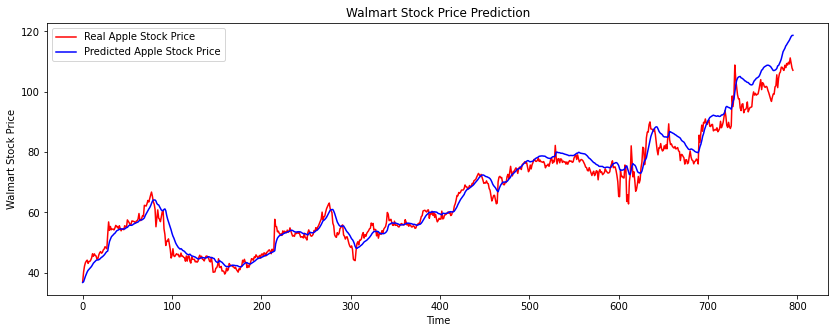

In [19]:
main()

